In [1]:
#pip install tensorflow scikit-learn matplotlib


In [2]:
import os
import json
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2

# Define the directory path
directory = r'C:\Users\bbartling\Desktop\HVACGraphicsClassifier\data\ahu'

# Initialize a counter for the annotations
annotation_counter = Counter()

# Function to apply Canny edge detection
def apply_canny_edge_detection(image):
    image = image.astype('uint8')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    return edges

# Function to load data with annotations
def load_data_with_annotations(src_dir, target_size=(224, 224)):
    images = []
    labels = []
    class_names = set()
    
    for file in os.listdir(src_dir):
        if file.endswith('.json'):
            json_path = os.path.join(src_dir, file)
            try:
                with open(json_path, 'r') as f:
                    annotation_data = json.load(f)
                
                for annotation in annotation_data:
                    img_file = annotation['image']
                    img_path = os.path.join(src_dir, img_file)
                    
                    if not os.path.exists(img_path):
                        print(f"Image {img_file} not found.")
                        continue
                    
                    for item in annotation['annotations']:
                        label = item['label']
                        class_names.add(label)
                        
                        # Load and preprocess image
                        img = load_img(img_path, target_size=target_size)
                        img_array = img_to_array(img)
                        
                        # Store original and Canny edge images
                        images.append(img_array)
                        labels.append(label)
                        
                        img_canny = apply_canny_edge_detection(img_array)
                        images.append(img_canny)
                        labels.append(label)
            except Exception as e:
                print(f"Error processing {file}: {e}")

    class_names = list(class_names)
    labels = [class_names.index(label) for label in labels]
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels, class_names

# Loop through the files in the directory and count annotations
for filename in os.listdir(directory):
    if filename.endswith('.xml.json'):
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as file:
            data = json.load(file)
            if isinstance(data, list):
                for item in data:
                    for annotation in item.get('annotations', []):
                        label = annotation.get('label')
                        annotation_counter[label] += 1
                        if label == "mixing_duct":
                            print(f"The file {filename} contains the annotation 'mixing_duct'.")
                            
            elif isinstance(data, dict):
                for annotation in data.get('annotations', []):
                    label = annotation.get('label')
                    annotation_counter[label] += 1

# Display the unique annotations and their frequency counts
print("Unique Annotations and Frequency Counts:")
for label, count in annotation_counter.items():
    print(f"{label}: {count}")

# Load data
images, labels, class_names = load_data_with_annotations(directory)

# Check if data is loaded correctly
print(f"Loaded {len(images)} images.")
print(f"Class names: {class_names}")


Unique Annotations and Frequency Counts:
return_fan: 14
supply_fan: 16
sensor: 71
damper: 38
afms: 2
mixing_air_duct: 11
outside_air_duct: 14
return_air_duct: 14
exhaust_air_duct: 15
supply_air_duct: 17
cool_coil: 10
heat_coil: 13
min_oa_air_duct: 2
air_flow_station: 4
cooling_coil: 5
exhaust_fan: 5
erv_wheel: 1
Loaded 532 images.
Class names: ['exhaust_fan', 'erv_wheel', 'sensor', 'air_flow_station', 'mixing_air_duct', 'outside_air_duct', 'afms', 'return_fan', 'cool_coil', 'supply_air_duct', 'damper', 'return_air_duct', 'heat_coil', 'min_oa_air_duct', 'cooling_coil', 'supply_fan', 'exhaust_air_duct']


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20


c:\Users\bbartling\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2408 - loss: 2.5408 - val_accuracy: 0.1682 - val_loss: 2.6383
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3174 - loss: 2.2768 - val_accuracy: 0.1495 - val_loss: 2.6913
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.2828 - loss: 2.3286 - val_accuracy: 0.1402 - val_loss: 2.7593
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.3145 - loss: 2.2145 - val_accuracy: 0.1215 - val_loss: 2.7191
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3380 - loss: 2.1385 - val_accuracy: 0.1121 - val_loss: 2.7376
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3213 - loss: 2.1713 - val_accuracy: 0.1402 - val_loss: 2.7710
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3294 - loss: 2.1434 - val_accuracy: 0.1308 - val_loss: 2.7466
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.3376 - loss: 2.1497 - val_accuracy: 0.1402 - val_loss: 2.8259
Epo

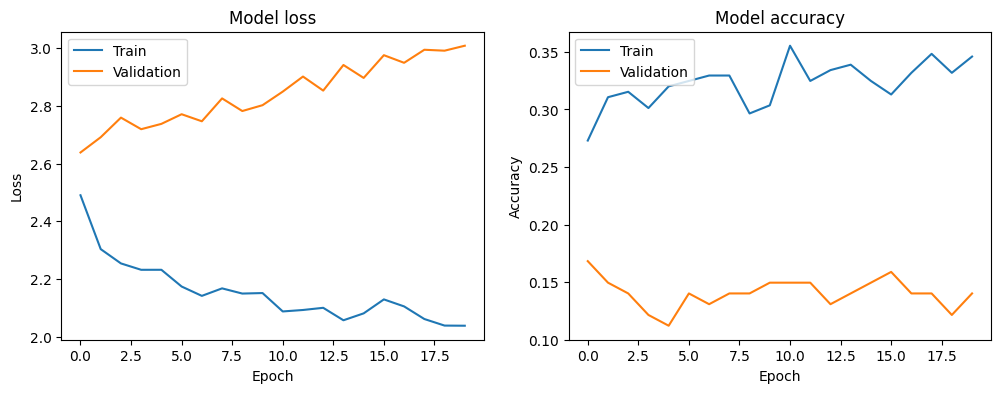

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Preprocess images for EfficientNetB0
images = tf.keras.applications.efficientnet.preprocess_input(images)

def create_model(input_shape, num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
        
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

# Split data into training and validation sets if data is loaded
if len(images) > 0:
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

    # Define ImageDataGenerator with augmentation for training data
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_datagen = ImageDataGenerator()

    # Create data generators
    train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
    val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

    # Create and train the model
    input_shape = (224, 224, 3)
    num_classes = len(class_names)
    model = create_model(input_shape, num_classes)
    history = model.fit(train_generator, validation_data=val_generator, epochs=20)  # Increased epochs for more training
    model.save(r'C:\Users\bbartling\Desktop\HVACGraphicsClassifier\models\hvac_classifier_efficientnet.keras')  # Updated saving format

    # Plot the training history
    plot_history(history)
else:
    print("No images found in the specified directory.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Image: test_ahu1.png
Predicted Label: damper
Prediction Scores: [0.0526673  0.00940141 0.08676151 0.04369731 0.02093141 0.09618769
 0.01777137 0.06052843 0.0398256  0.06418525 0.20265807 0.06153448
 0.05183167 0.01242701 0.02763368 0.08679609 0.06516176]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Image: test_ahu2.png
Predicted Label: damper
Prediction Scores: [0.06292991 0.00927978 0.08903446 0.02754195 0.01697048 0.05389431
 0.01974116 0.06819575 0.034889   0.06207846 0.23822275 0.05748698
 0.05258333 0.01885791 0.04698476 0.09665065 0.04465843]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Image: test_ahu3.png
Predicted Label: damper
Prediction Scores: [0.03070178 0.01221196 0.08183176 0.04191873 0.01440352 0.10236162
 0.01654588 0.1285823  0.03633502 0.06971362 0.1443389  0.04623874
 0.05480422 0.0078127  0.02690028 0.09423828 0.09106069]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Image: test_ahu4.png
Predicted Label: damper
Prediction Scores: [0.0376205  0.0061

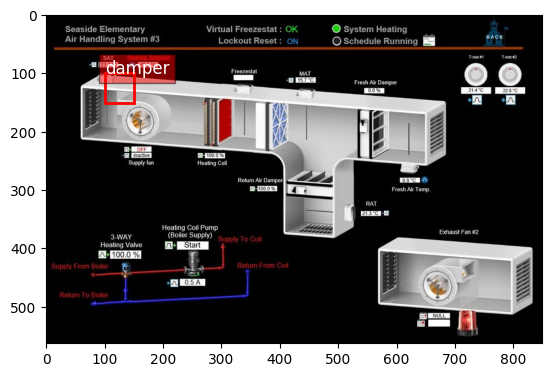

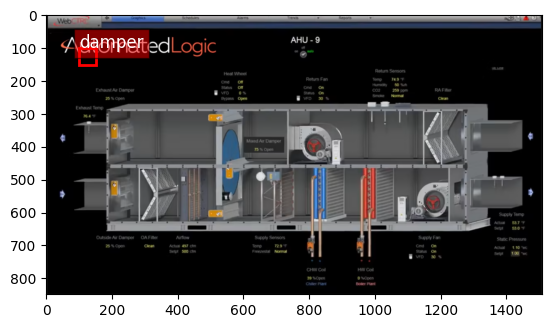

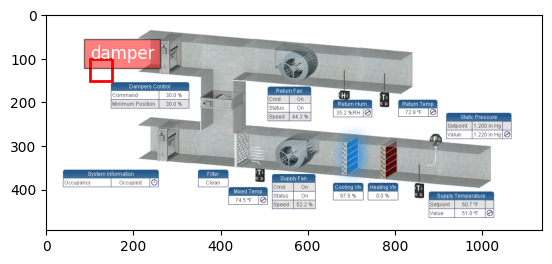

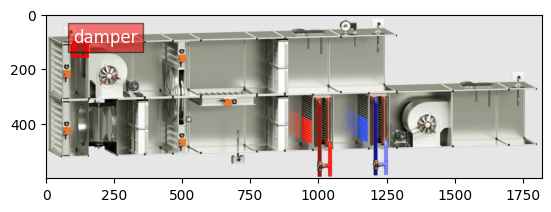

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to load and preprocess an image with Canny edge detection
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = apply_canny_edge_detection(img_array)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

# Function to predict the class of an image
def predict_image(model, image_path, class_names):
    img_array = load_and_preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = class_names[predicted_class]
    return predicted_label, predictions[0]

# Function to display an image with bounding boxes
def display_image_with_boxes(image_path, predicted_label, annotation_data):
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    img = load_img(image_path)
    img_array = img_to_array(img) / 255.0  # Rescale the image
    fig, ax = plt.subplots(1)
    ax.imshow(img_array)

    # Draw bounding boxes from annotation data
    for annotation in annotation_data:
        if annotation['label'] == predicted_label:
            coords = annotation['coordinates']
            x, y, width, height = coords['x'], coords['y'], coords['width'], coords['height']
            rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(x, y, annotation['label'], color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
    
    plt.show()

# Load the trained model
model_path = r'C:\Users\bbartling\Desktop\HVACGraphicsClassifier\models\hvac_classifier_efficientnet.keras'
model = tf.keras.models.load_model(model_path)

# Class names from training
# This variable is already loaded in previous cells and should be reused
# class_names = ["min_oa_air_duct", "mixing_air_duct", "return_fan", "outside_air_duct", "return_air_duct", "afms", "air_flow_station", "exhaust_fan", "erv_wheel", "sensor", "heat_coil", "exhaust_air_duct", "cooling_coil", "cool_coil", "supply_air_duct", "damper", "supply_fan"]

# Directory containing test images
test_images_dir = r'C:\Users\bbartling\Desktop\HVACGraphicsClassifier\data\test_images'

# Dictionary to store predictions and annotations
predictions_and_annotations = {}

# Predict each image in the test directory
for img_file in os.listdir(test_images_dir):
    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(test_images_dir, img_file)
        predicted_label, prediction_scores = predict_image(model, img_path, class_names)
        print(f"Image: {img_file}")
        print(f"Predicted Label: {predicted_label}")
        print(f"Prediction Scores: {prediction_scores}\n")

        # Assuming the annotations are stored in memory in the same format as the previous cell
        # You can modify this according to how you store annotations in memory
        annotations = [
            {
                "label": predicted_label, 
                "coordinates": {"x": 100, "y": 100, "width": 50, "height": 50}  # Example coordinates
            }
        ]
        
        # Store the results
        predictions_and_annotations[img_file] = {
            "predicted_label": predicted_label,
            "annotations": annotations
        }

# Display each image with bounding boxes
for img_file, data in predictions_and_annotations.items():
    img_path = os.path.join(test_images_dir, img_file)
    predicted_label = data['predicted_label']
    annotations = data['annotations']
    display_image_with_boxes(img_path, predicted_label, annotations)
